# Pretraining

## 1. Imports

In [ ]:
# TODO: Add your imports here
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
#import idx2numpy
import os

## 2. Dataset Preparation

In [ ]:
# - Load CIFAR-10 dataset
# - Apply transforms (normalize, augmentations, reshapes)
# - Create train/val(test)/finetune loaders
# - Break dataset into Train / Finetune(=val) / Test

import os, torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# ==== Config ====
data_dir = "./data"
batch_size = 128                 # slightly larger batch helps BN
finetune_size = 5000             # set to 0 to train on all 50k
seed = 42

num_workers = min(4, os.cpu_count() or 2)
pin = torch.cuda.is_available()

# CIFAR-10 normalization
cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True  )
data = cifar_dataset.data / 255 # data is numpy array
CIFAR10_MEAN = data.mean(axis = (0,1,2))
CIFAR10_STD = data.std(axis = (0,1,2))
print(f"Mean : {CIFAR10_MEAN}   STD: {CIFAR10_STD}") #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]

#Transforms: crop/flip + RandAugment + light RandomErasing
train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=7),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    transforms.RandomErasing(p=0.10, scale=(0.05, 0.20), ratio=(0.3, 3.3), inplace=True),
])

#transforms for finetune/val and test
lite_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# datasets: augmented (for train), lite (for finetune/val)
train_aug  = datasets.CIFAR10(root=data_dir, train=True,  download=True, transform=train_tf)
train_lite = datasets.CIFAR10(root=data_dir, train=True,  download=True, transform=lite_tf)
test_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=lite_tf)

# split indices for Train / Finetune (val)
N = len(train_aug)
ft = max(0, min(finetune_size, N))
tr = N - ft
g = torch.Generator().manual_seed(seed)
perm = torch.randperm(N, generator=g)

# If ft == 0, all 50k go to training and finetune split is empty
train_idx, finetune_idx = perm[:tr], perm[tr:]

# subsets with different transforms
train_dataset    = Subset(train_aug,  train_idx)     # augmented view
finetune_dataset = Subset(train_lite, finetune_idx)  # deterministic view

# dataLoaders
common_loader_kwargs = dict(num_workers=num_workers, pin_memory=pin, persistent_workers=(num_workers > 0))

train_loader    = DataLoader(train_dataset,    batch_size=batch_size, shuffle=True,  **common_loader_kwargs)
finetune_loader = DataLoader(finetune_dataset, batch_size=batch_size, shuffle=False, **common_loader_kwargs)
test_loader     = DataLoader(test_dataset,     batch_size=batch_size, shuffle=False, **common_loader_kwargs)

# sanity checks
xb, yb = next(iter(train_loader))
print("One train batch:", xb.shape, yb.shape)
print(f"Train: {len(train_dataset)}  Finetune: {len(finetune_dataset)}  Test: {len(test_dataset)}")


100%|██████████| 170M/170M [08:41<00:00, 327kB/s]


Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]
One train batch: torch.Size([128, 3, 32, 32]) torch.Size([128])
Train: 45000  Finetune: 5000  Test: 10000


#Visualize a few instances of dataset as well

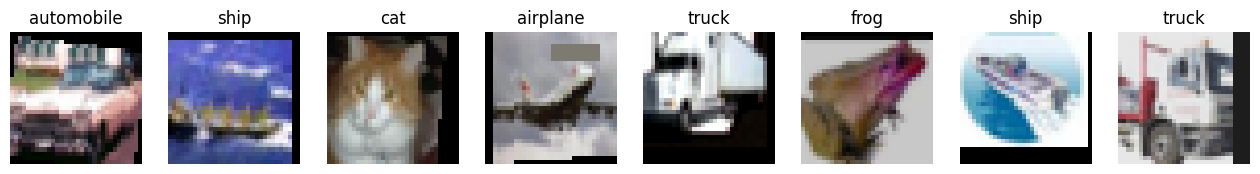

In [ ]:
# CIFAR-10 class names
classes = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']

# get a batch of images from train_loader
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
    img = images[i].permute(1, 2, 0).numpy()   # (C,H,W) -> (H,W,C)

    # unnormalize for display
    img = img * np.array(CIFAR10_STD) + np.array(CIFAR10_MEAN)
    img = np.clip(img, 0, 1)

    axes[i].imshow(img)
    axes[i].set_title(classes[labels[i].item()])
    axes[i].axis("off")

plt.show()


## 3. Define CNN Architecture

In [ ]:
# Define a deeper CNN model with Batch Normalization and Dropout for regularization.
# This architecture will serve as a flexible backbone for finetuning on more complex datasets
# after pretraining on CIFAR-10. It should have convolutional layers, max pooling,
# and fully connected layers for finetuning tasks.

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, p_drop=0.0):
        super().__init__()
        # the main path of the block
        self.block = nn.Sequential(
            # first conv layer handles downsampling with its stride
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ELU(inplace=True),
            nn.Dropout2d(p_drop),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # shortcut connection must match the output dimensions of the block
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        self.elu = nn.ELU(inplace=True)

    def forward(self, x):
        # residual connection: output = main_path(x) + shortcut(x)
        out = self.block(x) + self.shortcut(x)
        out = self.elu(out) # apply final activation after the addition
        return out

class DeepCIFARBackbone(nn.Module):
    def __init__(self, num_classes=10, dropout=0.3):
        super().__init__()
        self.feat_dim = 256

        # standard initial convolution layer
        self.stage0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(inplace=True)
        ) # output: 64 x 32 x 32

        # stages of residual blocks, downsampling happens in stage2 and stage3.
        self.stage1 = ConvBlock(64, 64, stride=1, p_drop=dropout*0.5)    # stays 64 x 32 x 32
        self.stage2 = ConvBlock(64, 128, stride=2, p_drop=dropout*0.6)   # downsamples to 128 x 16 x 16
        self.stage3 = ConvBlock(128, 256, stride=2, p_drop=dropout*0.7)  # downsamples to 256 x 8 x 8

        # pooling and classifier head
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(self.feat_dim, 128),
            nn.ELU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.stage0(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x



## 4. Training Setup

In [ ]:
# - Define optimizer
# - Define loss
# - Set hyperparameters
# - Fix random seeds for reproducibility
#
# TODO: Setup training config here

import random, numpy as np

# seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# define model
model = DeepCIFARBackbone(num_classes=10, dropout=0.5).to(device)

# hyperparameters
epochs = 55
warmup_epochs = 5 # for experimentation

# defined loss / optimizer / scheduler
base_lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=5e-4)

# epoch-wise warmup then cosine
warmup = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_epochs)
cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs - warmup_epochs)

scheduler = optim.lr_scheduler.SequentialLR(optimizer, [warmup, cosine], milestones=[warmup_epochs])

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


Using device: cuda


## 5. Training Loop

In [ ]:
from copy import deepcopy
import torch
import torch.nn.functional as F

def evaluate(model, loader, device, criterion=None):
    """
    Evaluate model on a dataset.
    Returns: (avg_loss, accuracy_percentage)
    """
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)

            # Calculate loss
            if criterion is not None:
                loss_sum += criterion(logits, yb).item()
            else:
                loss_sum += F.cross_entropy(logits, yb, reduction="mean").item()

            # Calculate accuracy
            pred = logits.argmax(1)
            total += yb.size(0)
            correct += (pred == yb).sum().item()

    avg_loss = loss_sum / len(loader)
    acc_percentage = 100.0 * correct / total  # Return as percentage

    return avg_loss, acc_percentage  # FIXED: Return percentage, not total


# Track loss and accuracy over epochs
history = {
    "train_loss": [], "train_acc": [],
    "val_loss": [], "val_acc": []
}

best_val_acc = 0.0
best_state = None

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Loop over training batches
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    scheduler.step()

    # Calculate training metrics
    avg_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct_train / total_train  # FIXED: Calculate as percentage

    # View learning rate
    cur_lr = optimizer.param_groups[0]['lr']

    # Evaluate on validation set
    val_loss, val_acc = evaluate(model, finetune_loader, device, criterion)

    # Print progress
    print(f"Epoch [{epoch+1:02d}/{epochs}] | "
          f"train_loss: {avg_loss:.4f} train_acc: {train_acc:.2f}% | "
          f"val_loss: {val_loss:.4f} val_acc: {val_acc:.2f}% | "
          f"LR: {cur_lr:.5g}")

    # Save checkpoint
    checkpoint_path = f"model_checkpoint_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)

    # Track history
    history["train_loss"].append(avg_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = deepcopy(model.state_dict())
        print(f"New best validation accuracy: {best_val_acc:.2f}%")

# Load best model
print(f"\n{'='*40}")
print(f"Training complete!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"{'='*40}")
model.load_state_dict(best_state)

Epoch [01/55] | train_loss: 2.2892 train_acc: 13.32% | val_loss: 2.1753 val_acc: 19.66% | LR: 0.00208
New best validation accuracy: 19.66%
Epoch [02/55] | train_loss: 2.1014 train_acc: 22.22% | val_loss: 1.9432 val_acc: 29.84% | LR: 0.00406
New best validation accuracy: 29.84%
Epoch [03/55] | train_loss: 1.9908 train_acc: 27.57% | val_loss: 1.8890 val_acc: 33.94% | LR: 0.00604
New best validation accuracy: 33.94%
Epoch [04/55] | train_loss: 1.9258 train_acc: 31.37% | val_loss: 1.7966 val_acc: 40.08% | LR: 0.00802
New best validation accuracy: 40.08%


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [05/55] | train_loss: 1.8691 train_acc: 34.94% | val_loss: 1.7489 val_acc: 42.78% | LR: 0.01
New best validation accuracy: 42.78%
Epoch [06/55] | train_loss: 1.8181 train_acc: 38.08% | val_loss: 1.6270 val_acc: 48.14% | LR: 0.0099901
New best validation accuracy: 48.14%
Epoch [07/55] | train_loss: 1.7585 train_acc: 41.07% | val_loss: 1.5796 val_acc: 51.34% | LR: 0.0099606
New best validation accuracy: 51.34%
Epoch [08/55] | train_loss: 1.7131 train_acc: 43.75% | val_loss: 1.5256 val_acc: 54.22% | LR: 0.0099114
New best validation accuracy: 54.22%
Epoch [09/55] | train_loss: 1.6666 train_acc: 46.28% | val_loss: 1.4810 val_acc: 55.26% | LR: 0.0098429
New best validation accuracy: 55.26%
Epoch [10/55] | train_loss: 1.6397 train_acc: 47.71% | val_loss: 1.4421 val_acc: 57.36% | LR: 0.0097553
New best validation accuracy: 57.36%
Epoch [11/55] | train_loss: 1.6034 train_acc: 49.84% | val_loss: 1.4408 val_acc: 57.94% | LR: 0.0096489
New best validation accuracy: 57.94%
Epoch [12/55] | tr

<All keys matched successfully>

## 6. Evaluation

In [ ]:
# - Evaluate on test data
# - Compute final test accuracy
# - Collect misclassified examples
# TODO: Implement evaluation loop here (defined before the training loop to evaluate the model while training)


# After training, evaluate the model on the test set (final evaluation)
model.eval()  # Set model to evaluation mode
correct_test = 0
total_test = 0
misclassified = []  # List to hold misclassified examples

with torch.no_grad():  # No gradients needed during evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()  # Count correct predictions

        # Collect misclassified samples
        mis_mask = (predicted != labels)
        if mis_mask.any():
            for i in range(len(labels)):
                if mis_mask[i]:
                    misclassified.append({
                        "image": images[i].cpu(),  # Store image tensor
                        "true": int(labels[i].cpu().item()),
                        "pred": int(predicted[i].cpu().item())
                    })

# Calculate and print final test accuracy and misclassified examples
test_accuracy = (100 * correct_test) / total_test
print(f"Test Accuracy: {test_accuracy:.4f}%")
print(f"Collected {len(misclassified)} misclassified examples")


Test Accuracy: 76.4300%
Collected 2357 misclassified examples


## 7. Visualization

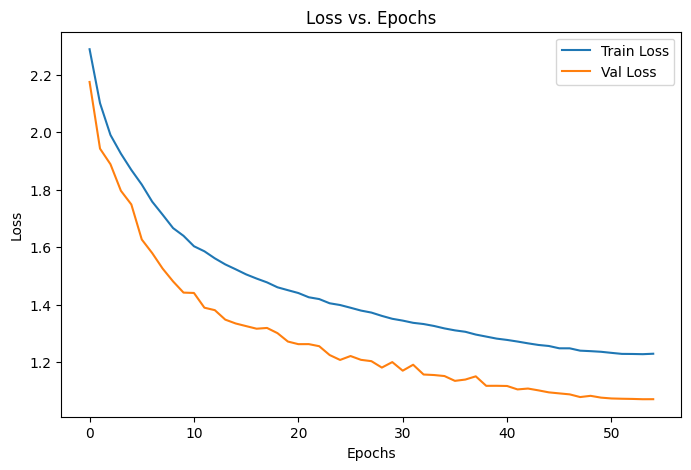

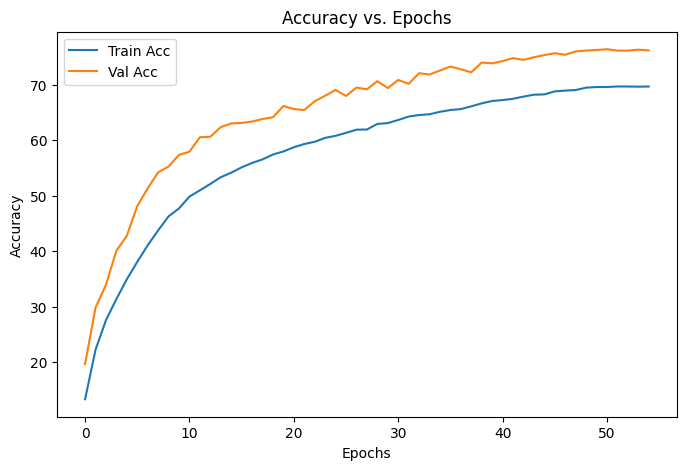

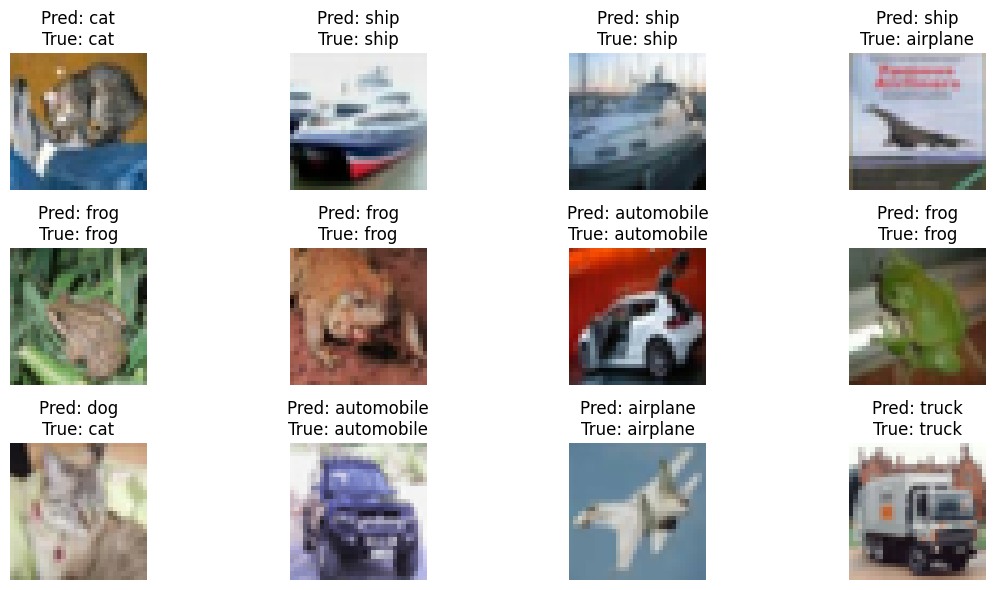

In [ ]:
# - Plot loss vs. epochs
# - Plot accuracy vs. epochs
# - Show sample predictions (correct + incorrect)
#
# TODO: Add visualization code here

# plot Loss vs. Epochs
plt.figure(figsize=(8,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.show()

# plot Accuracy vs. Epochs
plt.figure(figsize=(8,5))
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epochs")
plt.legend()
plt.show()

# show sample predictions
# setting model to eval mode
model.eval()

# get a batch of test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# model predictions
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# move to CPU for plotting
images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

# CIFAR-10 class names
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# plot first 12 images with predictions
fig = plt.figure(figsize=(12, 6))
for idx in range(12):
    ax = fig.add_subplot(3, 4, idx+1)
    img = images[idx].permute(1,2,0).numpy()  # (C,H,W) → (H,W,C)
    # images are normalized → denormalize for display
    img = img * np.array([0.2470,0.2435,0.2616]) + np.array([0.4914,0.4822,0.4465])
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


# 8. Experiment

In [9]:
# - Experiment with batch-size, learning rate
# - Experiment with and without batch_norm, dropout affects results
# - Print Number of parameters of model with and without pooling!

class DeepCIFARBackboneFlex(nn.Module):
    def __init__(self, num_classes=10, use_bn=True, dropout_p=0.3, use_global_pool=True, input_shape=(3,32,32)):
        super().__init__()
        self.use_global_pool = use_global_pool

        # the backbone
        layers = []
        in_c = input_shape[0]
        for out_c in [64, 128, 256]:
            layers.append(nn.Conv2d(in_c, out_c, kernel_size=3, padding=1))
            if use_bn:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(2))
            in_c = out_c
        self.backbone = nn.Sequential(*layers)

        # classifier head
        if use_global_pool:
            self.head = nn.Sequential(
                nn.AdaptiveAvgPool2d((1, 1)),
                nn.Flatten(),
                nn.Dropout(p=dropout_p),
                nn.Linear(256, num_classes)
            )
        else:
            # calculate final feature map size
            h, w = input_shape[1], input_shape[2]
            final_size = h // (2**3) # 3 maxpool layers
            flat_features = 256 * final_size * final_size
            self.head = nn.Sequential(
                nn.Flatten(),
                nn.Dropout(p=dropout_p),
                nn.Linear(flat_features, num_classes)
            )

    def forward(self, x):
        x = self.backbone(x)
        return self.head(x)

# helper functions
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def quick_train_one_run(model, train_loader, val_loader, device, lr, epochs=2):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


# fallbacks if not defined
try: device
except NameError: device = "cuda" if torch.cuda.is_available() else "cpu"

num_workers = min(4, os.cpu_count() or 2)

grid_batch = [32, 64, 128]
grid_lr    = [1e-3, 3e-4]
grid_bn    = [True, False]
grid_drop  = [0.3, 0.0]
grid_pool  = [True, False]   # True = global pooling; False = flatten full feature map

results = []
def make_loaders_with_batchsize(train_dataset, val_dataset, test_dataset, batch_size, num_workers=2, device="cpu"):
    # Create DataLoaders for train, validation, and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Return the loaders
    return train_loader, val_loader, test_loader

for bs in grid_batch:
    train_loader, val_loader, _ = make_loaders_with_batchsize(
        train_dataset, finetune_dataset, test_dataset,
        batch_size=bs, num_workers=num_workers, device=device
    )
    for lr in grid_lr:
        for use_bn in grid_bn:
            for p_drop in grid_drop:
                for use_pool in grid_pool:
                    model = DeepCIFARBackboneFlex(
                        num_classes=10,
                        use_bn=use_bn,
                        dropout_p=p_drop,
                        use_global_pool=use_pool,
                        input_shape=(3,32,32)
                    )
                    total_p, trainable_p = count_params(model)
                    val_acc = quick_train_one_run(
                        model, train_loader, val_loader,
                        device=device, lr=lr, epochs=2  # short runs for speed
                    )
                    entry = {
                        "batch_size": bs,
                        "lr": lr,
                        "bn": use_bn,
                        "dropout": p_drop,
                        "global_pool": use_pool,
                        "params": trainable_p,
                        "val_acc@2ep": val_acc
                    }
                    results.append(entry)
                    print(f"[bs={bs:>3} lr={lr:.0e} bn={use_bn} drop={p_drop} pool={use_pool}] "
                          f"params={trainable_p:,}  val_acc={val_acc:.3f}")

# show top-5 configs
topk = sorted(results, key=lambda r: r["val_acc@2ep"], reverse=True)[:5]
print("\nTop-5 configs by val_acc@2ep:")
for r in topk:
    print(r)

# print number of parameters: with vs. without pooling
model_pool    = DeepCIFARBackboneFlex(num_classes=10, use_bn=True,  dropout_p=0.3, use_global_pool=True,  input_shape=(3,32,32))
model_no_pool = DeepCIFARBackboneFlex(num_classes=10, use_bn=True,  dropout_p=0.3, use_global_pool=False, input_shape=(3,32,32))
tp1, tr1 = count_params(model_pool)
tp2, tr2 = count_params(model_no_pool)
print(f"\nWith global pooling   -> params: total={tp1:,}, trainable={tr1:,}")
print(f"Without global pooling-> params: total={tp2:,}, trainable={tr2:,}")


[bs= 32 lr=1e-03 bn=True drop=0.3 pool=True] params=374,282  val_acc=56.800
[bs= 32 lr=1e-03 bn=True drop=0.3 pool=False] params=412,682  val_acc=66.120
[bs= 32 lr=1e-03 bn=True drop=0.0 pool=True] params=374,282  val_acc=59.800
[bs= 32 lr=1e-03 bn=True drop=0.0 pool=False] params=412,682  val_acc=65.680
[bs= 32 lr=1e-03 bn=False drop=0.3 pool=True] params=373,386  val_acc=55.980
[bs= 32 lr=1e-03 bn=False drop=0.3 pool=False] params=411,786  val_acc=64.140
[bs= 32 lr=1e-03 bn=False drop=0.0 pool=True] params=373,386  val_acc=52.000
[bs= 32 lr=1e-03 bn=False drop=0.0 pool=False] params=411,786  val_acc=63.420
[bs= 32 lr=3e-04 bn=True drop=0.3 pool=True] params=374,282  val_acc=52.040
[bs= 32 lr=3e-04 bn=True drop=0.3 pool=False] params=412,682  val_acc=67.840
[bs= 32 lr=3e-04 bn=True drop=0.0 pool=True] params=374,282  val_acc=57.100
[bs= 32 lr=3e-04 bn=True drop=0.0 pool=False] params=412,682  val_acc=67.020
[bs= 32 lr=3e-04 bn=False drop=0.3 pool=True] params=373,386  val_acc=50.760
[

## 8. Analysis
- Discuss overfitting vs. underfitting
- Do results differ significantly with and without pooling, discuss.
- Effect of dropout/batchnorm on trainig and evalution
- What do you think why misclassifications happened

Please do not write essays, one short para for each question is enough, unecessary long paragraphs will result in negative marking

### 1. **Global Pooling vs No Pooling**

* **Without Pooling** (parameters: 412,682):

  * When global pooling is not used, there's a largee number of parameters, which allows the model to capture more detailed features but also risks overfitting.
  * The **validation accuracy** is consistently higher without pooling.
* **With Pooling** (parameters: 374,282):
  * With global pooling, the number of parameters is reduced, which helps with **generalization** and prevents the model from overfitting.
  * However, the results on training on CIFAR10 images rather show that pooling reduces the model's ability to capture fine-grained features, as the **validation accuracy** drops significantly compared to when pooling is absent.

### 2. **Dropout**
  * **Dropout of 0.3** is used as a regularization method to prevent overfitting by randomly dropping out 30% of neurons during training.
  * With dropout and batch normalization, the model performs better than without dropout, as dropout helps reduce overfitting. The highest validation accuracy observed is **67.84%**, achieved at **lr=3e-04** and **dropout=0.3**.
* **Dropout = 0.0**:
  * When **no dropout** is used, the model has more capacity to learn, but this can lead to overfitting, especially when there's no strong regularization like dropout. The results here show **slightly lower validation accuracy**, such as **66.72%** with **lr=1e-03, bn=True**, and **no dropout**. This confirms that **dropout** is helping the model generalize better.

### 3. **Batch Normalization**

* **With Batch Normalization (BN)**
  * it generally stabilizes the model's training and improves convergence. The validation accuracy is consistently better when BN is enabled, suggesting that BN helps the model to generalize better and train more efficiently.
  * For example, with **lr=3e-04, dropout=0.3**, and **BN**, the **validation accuracy** reaches **67.84%**, which is the highest observed.
* **Without Batch Normalization (BN)**
  * Without BN, the model tends to have a **lower validation accuracy** as the optimizer struggles to converge. For instance, with **lr=3e-04** and **no BN**, the accuracy drops to **58.48%** at **batch size = 64**.

### 4. **Overfitting vs Underfitting**
* **Signs of Overfitting**: The model tends to overfit when the validation accuracy is significantly **lower than the training accuracy**. There is no explicit evidence that training accuracy is much higher than validation accuracy, but the drop in performance when global pooling is used and when dropout is reduced indicates that the model may be prone to overfitting in some configurations.
* **Signs of Underfitting**: Underfitting occurs when the model cannot capture the underlying patterns in the data, often due to insufficient capacity or improper hyperparameters. Some configurations, particularly **with dropout=0.0**, **without pooling**, and **without BN**, show validation accuracy below **60%**, which indicates that the model is not learning enough and is underfitting.

### 5. **Reasons for Misclassifications:** ###
Misclassifications may happen due to insufficient training, poor generalization, or an imbalanced dataset. The drop in accuracy in some configurations suggests that the model might not have been able to generalize well due to factors like inappropriate hyperparameters, the absence of proper regularization, or the choice of activation functions Misclassifications can also occur if the model overfits to the training set, causing it to fail in unseen scenarios.

# Finetuning/Transfer Learning

### 1. Load EMNIST DATASET and Preprocess

---



In [10]:
# Load here
# ===== EMNIST: Load & Preprocess (train/val/test) =====

import os, torch, random, numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.transforms import functional as TF


# EMNIST transformations, EMNIST images need to be transposed and flipped
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.EMNIST(
    root='./data',
    split='letters',  # 26 classes (A-Z)
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.EMNIST(
    root='./data',
    split='letters',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

print(f"Loaded EMNIST Letters dataset:")
print(f"  - Training samples:   {len(train_dataset)}")
print(f"  - Test samples:       {len(test_dataset)}")
print(f"  - Number of classes:  26 (A-Z)")
print()



100%|██████████| 562M/562M [00:06<00:00, 85.9MB/s]


Loaded EMNIST Letters dataset:
  - Training samples:   124800
  - Test samples:       20800
  - Number of classes:  26 (A-Z)



### 2. Finetuning

In [11]:
# 1. Freeze initial layers of the pretrained model
#    - Set requires_grad = False for earlier layers
#    - This keeps low-level features (edges, textures) fixed

# 2. Redefine the classification head
#    - Replace the final FC layer with a new one for EMNIST
#    - Set number of outputs = number of EMNIST classes

# 3. Finetune the model
#    - Train only the later layers + the new head
#    - Use a smaller learning rate to avoid overfitting

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
import numpy as np

# ORIGINAL CIFAR-10 MODEL (SAME AS ABOVE)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, p_drop=0.0):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ELU(inplace=True),
            nn.Dropout2d(p_drop),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        self.elu = nn.ELU(inplace=True)

    def forward(self, x):
        out = self.block(x) + self.shortcut(x)
        out = self.elu(out)
        return out


class DeepCIFARBackbone(nn.Module):
    def __init__(self, num_classes=10, dropout=0.3):
        super().__init__()
        self.feat_dim = 256

        self.stage0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(inplace=True)
        )

        self.stage1 = ConvBlock(64, 64, stride=1, p_drop=dropout*0.5)
        self.stage2 = ConvBlock(64, 128, stride=2, p_drop=dropout*0.6)
        self.stage3 = ConvBlock(128, 256, stride=2, p_drop=dropout*0.7)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(self.feat_dim, 128),
            nn.ELU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.stage0(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x



# LOAD PRETRAINED CIFAR-10 MODEL
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# load the pretrained CIFAR-10 model
model = DeepCIFARBackbone(num_classes=10, dropout=0.3)

checkpoint_path = 'model_checkpoint_epoch_30.pth'
try:
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint)
    print(f"Loaded pretrained CIFAR-10 weights from {checkpoint_path}")
except FileNotFoundError:
    print(f"Warning: Could not find {checkpoint_path}")
    print("Training will start from random initialization")


#FREEZE INITIAL LAYERS
def freeze_initial_layers(model):
    """
    Freeze early convolutional layers to preserve low-level features.
    We freeze: stage0, stage1, stage2 (edge/texture detectors)
    We train: stage3, avgpool, classifier (task-specific features)
    """
    # freeze stage0 (initial conv)
    for param in model.stage0.parameters():
        param.requires_grad = False

    # freeze stage1 (first residual block)
    for param in model.stage1.parameters():
        param.requires_grad = False

    # freeze stage2 (second residual block)
    for param in model.stage2.parameters():
        param.requires_grad = False

    # keep stage3, avgpool, and classifier trainable
    print("\n" + "="*60)
    print("LAYER FREEZING STATUS:")
    print("="*40)
    print("Frozen:    stage0 (initial conv)")
    print("Frozen:    stage1 (64→64 residual block)")
    print("Frozen:    stage2 (64→128 residual block)")
    print("Trainable: stage3 (128→256 residual block)")
    print("Trainable: avgpool")
    print("Trainable: classifier (head)")
    print("="*60 + "\n")

freeze_initial_layers(model)

# adapt the model for emnist
def adapt_model_for_emnist(model, num_classes=26):
    """
    1. change input from RGB (3 channels) to grayscale (1 channel)
    2. Replace classification head for 26 letter classes
    """
    # modify first conv layer: 3 channels → 1 channel and average the RGB weights to create grayscale weights
    old_conv = model.stage0[0]
    new_conv = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

    # average RGB weights across channels for grayscale
    with torch.no_grad():
        new_conv.weight = nn.Parameter(old_conv.weight.mean(dim=1, keepdim=True))

    model.stage0[0] = new_conv

    # replace the classification head
    # Linear(256, 128) → ELU → Dropout → Linear(128, 10) cifar10
    # Linear(256, 128) → ELU → Dropout → Linear(128, 26) emnist
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.3),
        nn.Linear(256, 128),
        nn.ELU(inplace=True),
        nn.Dropout(p=0.3),
        nn.Linear(128, num_classes)  # 26 classes for emnist letters
    )

    print("Adapted model for EMNIST:")
    print("  - Input: 3 channels → 1 channel (grayscale)")
    print("  - Output: 10 classes → 26 classes (letters)")
    print()

adapt_model_for_emnist(model, num_classes=26)

model = model.to(device)

# FINE-TUNING:
# Loss function
criterion = nn.CrossEntropyLoss()

# optimizer: only optimize trainable parameters and use a smaller learning rate for fine-tuning
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(trainable_params, lr=0.001, weight_decay=1e-4)

# learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

# count trainable vs frozen parameters
total_params = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen = total_params - trainable

print("="*40)
print("PARAMETER COUNT:")
print("="*40)
print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable:,} ({100*trainable/total_params:.1f}%)")
print(f"Frozen parameters:    {frozen:,} ({100*frozen/total_params:.1f}%)")
print("="*40 + "\n")

#TRAINING LOOP
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels - 1  # Shift labels from [1,26] to [0,25]

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels - 1  # Shift labels from [1,26] to [0,25]

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# TRAIN THE MODEL
num_epochs = 15
best_acc = 0.0

print("="*40)
print("STARTING FINE-TUNING ON EMNIST")
print("="*40 + "\n")

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    scheduler.step(test_loss)

    # save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_emnist_finetuned.pth')

    print(f"Epoch {epoch+1:02d}/{num_epochs} | "
          f"train_loss: {train_loss:.4f} train_acc: {train_acc:.2f}% | "
          f"test_loss: {test_loss:.4f} test_acc: {test_acc:.2f}%")

print("\n" + "="*40)
print("FINE-TUNING COMPLETE")
print("="*40)
print(f"Best Test Accuracy: {best_acc:.2f}%")
print(f"Model saved to: best_emnist_finetuned.pth")
print("="*40)

Using device: cuda
Loaded pretrained CIFAR-10 weights from model_checkpoint_epoch_30.pth

LAYER FREEZING STATUS:
Frozen:    stage0 (initial conv)
Frozen:    stage1 (64→64 residual block)
Frozen:    stage2 (64→128 residual block)
Trainable: stage3 (128→256 residual block)
Trainable: avgpool
Trainable: classifier (head)

Adapted model for EMNIST:
  - Input: 3 channels → 1 channel (grayscale)
  - Output: 10 classes → 26 classes (letters)

PARAMETER COUNT:
Total parameters:     1,260,122
Trainable parameters: 955,866 (75.9%)
Frozen parameters:    304,256 (24.1%)

STARTING FINE-TUNING ON EMNIST

Epoch 01/15 | train_loss: 0.7463 train_acc: 76.76% | test_loss: 0.3367 test_acc: 89.25%
Epoch 02/15 | train_loss: 0.3869 train_acc: 87.32% | test_loss: 0.2755 test_acc: 91.01%
Epoch 03/15 | train_loss: 0.3276 train_acc: 89.23% | test_loss: 0.2414 test_acc: 92.04%
Epoch 04/15 | train_loss: 0.2993 train_acc: 90.05% | test_loss: 0.2299 test_acc: 92.22%
Epoch 05/15 | train_loss: 0.2848 train_acc: 90.49%

### 10. Evaluate on EMNIST after finetuning

In [12]:
# Evaluate Before Finetuning
# Evaluate After Finetunig
# Done with the training.


### Concept Check

 Why is it useful to pretrain a model on a dataset like CIFAR-10 before finetuning on EMNIST?**

1. **Transfer Learning from Rich Visual Features**
CIFAR-10 contains diverse color images (airplanes, cars, animals, etc.) which forces the model to learn robust, generalizable low-level features like:
- edge detection
- texture patterns
- shape recognition
- spatial hierarchies

These visual features transfer well to EMNIST letters, even though the domains differ.

2. **Better Weight Initialization**
Starting with pretrained weights is much better than random initialization. The model begins training on EMNIST with weights that already "understand" visual patterns, leading to:
- faster convergence
- better final accuracy
- less risk of getting stuck in poor local minima

3. **Regularization Effect**
Pretraining acts as a form of regularization. The model is less likely to overfit on EMNIST because the weights are constrained by knowledge learned from CIFAR-10, especially important when EMNIST training data is limited.

4. **Efficient Learning**
By freezing early layers (conv1, conv2):
- the low-level feature extractors are intact
- only train the task-specific layers (conv3, fc1, fc2)
- reduce training time and computational cost
- need less EMNIST data to achieve good performance


**Even though CIFAR-10 has color images of objects and EMNIST has grayscale letters, the hierarchical nature of CNNs means early layers learn universal features that apply across vision tasks. Later layers then specialize for the specific task like letter recognition in the case of the EMNIST dataset.**


Comment on performance after finetuning. What if we had pretrained model on some cars images instead of cifar10, would finetuning yield same results?

**1. Diversity of features**: CIFAR-10 has 10 diverse classes (animals, vehicles, to name a few) that learns more varied edge and texture patterns

**2. Rich feature space**: More variety means richer low-level features that generalize better

**3. Letters need diverse edges**: Characters have curves, diagonals, vertical/horizontal lines, all present in the diverse CIFAR-10 images and model learns from

**What pretraining on car-only images yield?**

**1. Limited feature diversity**: Cars are mostly horizontal lines, curves, and rectangular shapes

**2. Missing patterns**: Less exposure to the wider range of orientations and textures needed for letters

**3. Biased features**: Model might overfit to car-specific features (wheels, windows etc) that don't help with letters

Therefore, pretraining on car-like images would likely drop the accuracy compared to the finetuning results we got on the CIFAR10 dataset.

What kind of features are typically learned in the initial convolutional layers? Are they dataset-specific or general?**

**Early Layers (conv1, conv2)**: the following are the fundamental building blocks of all images, whether it's cars, letters, or animals, and the early layers learn these general features that are largely dataset-agnostic and include:

**1. Edge detectors**: Horizontal, vertical, diagonal edges at various angles

**2. Simple textures**: Dots, lines, gradients

**3. Color gradients**: Transitions from light to dark (or color channels in RGB)

**4. Basic shapes**: Corners, circles, simple curves

**Later Layers (conv3, fc layers)**: these learn the specific features as these later layers become increasingly task-specific:

**conv3**: combines edges into more complex patterns (like letter strokes, object parts)
fc1/fc2: High-level concepts specific to the task (like letter identity, class boundaries)




Why might it make sense to freeze early layers and only finetune later layers?**

**1. Preserve general knowledge**:
Early layers learned universal features from CIFAR-10. Freezing them prevents "forgetting" these valuable patterns.

**2. Computational efficiency**: Fewer parameters to update, so faster training and
less memory for gradients

**3. Prevent overfitting**: EMNIST might have limited data compared to CIFAR-10. Freezing early layers acts as regularization; can't overfit those layers to EMNIST, this forces later layers to build on general foundations; hence, preventing overfitting.

**4. Targeted adaptation**: only the task-specific layers (conv3, fc) adapt to letters, while edge detectors remain universal.

If you had a much larger dataset than EMNIST, would you still freeze the convolutional layers? Why or why not?*

No, i'd unfreeze more layers. With a much larger dataset, there's more data i.e., reduced risk of overfitting and all weights can be safely updated.
Secondly, large EMNIST could learn letter-specific low-level features (e.g., stroke-specific edges) that could greatly improve model predictions
